<a href="https://colab.research.google.com/github/Mkhan2317/Market_Risk_Modelling_With_Var_and_Expected_Shortfall/blob/main/Market_Risk_Modelling_with_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

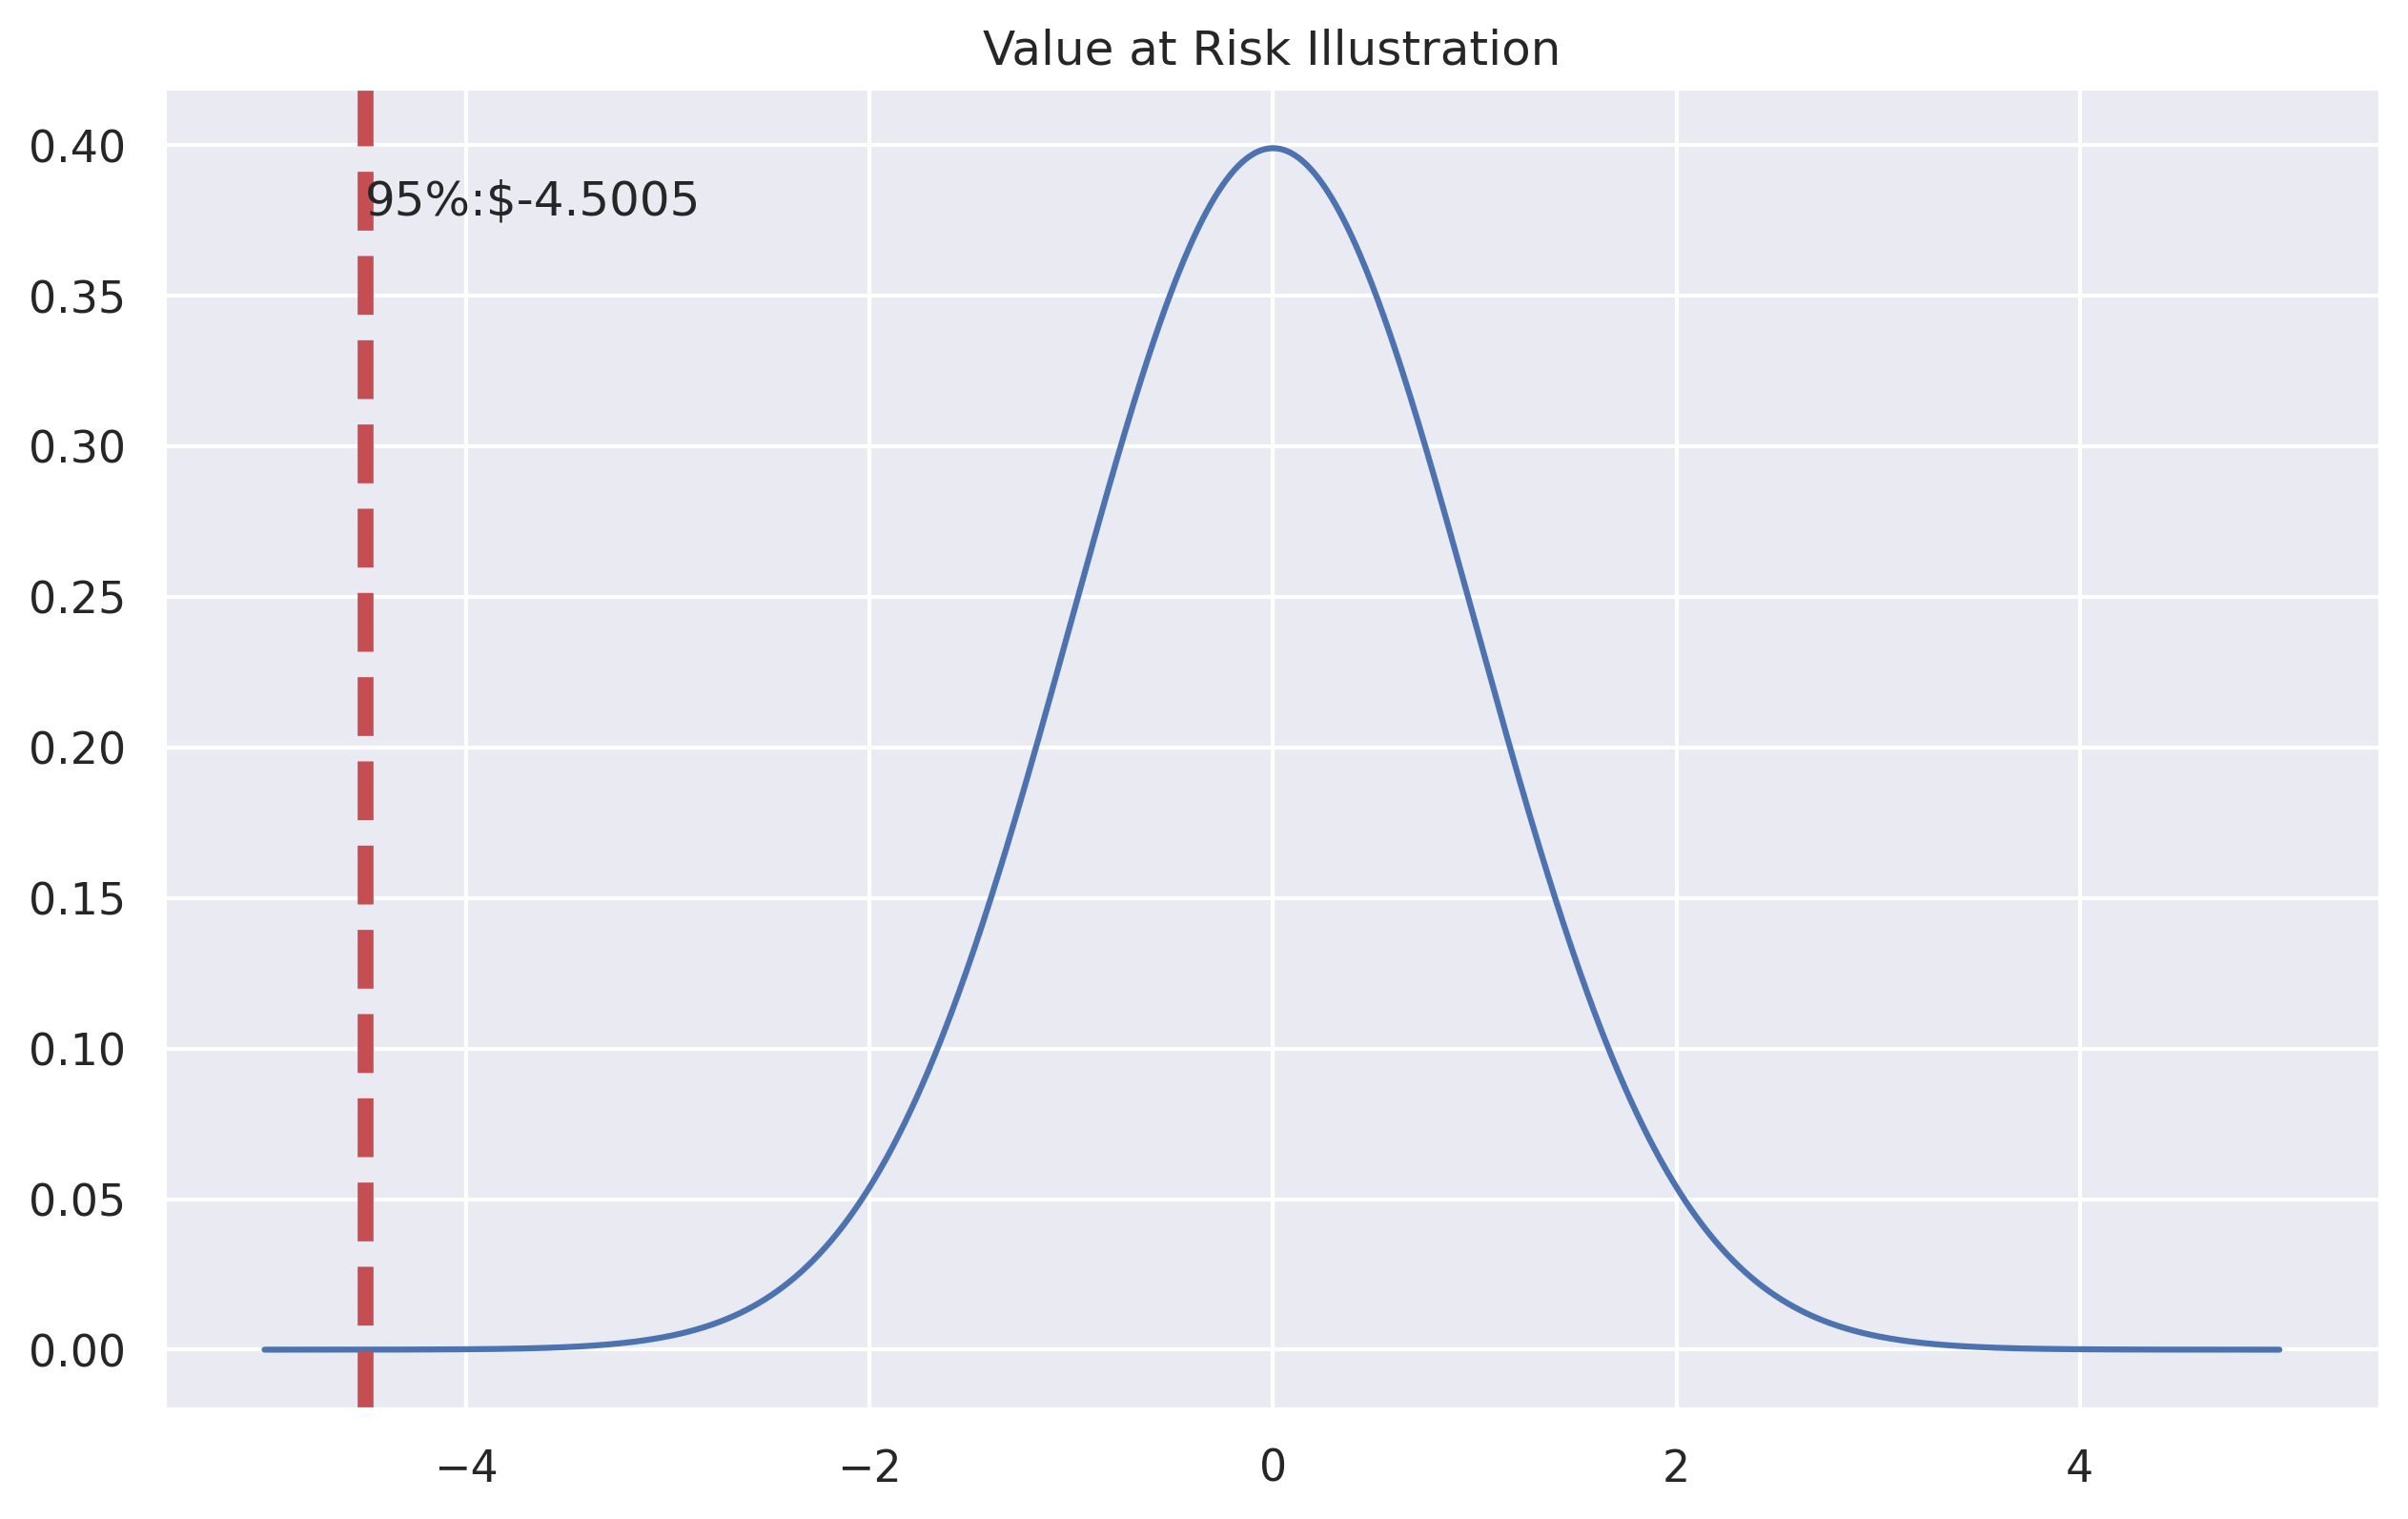

In [2]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [3]:
def getDailyData(symbol):
    import yfinance as yf
    data = yf.download(symbol, start='2020-01-01', end='2020-12-31', progress=False)
    data = data.rename_axis('timestamp')
    data = data.rename(columns={'Close': 'close'})
    return data

In [4]:
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    # Ensure we append a 1-D Series, not a (n,1) frame
    s = getDailyData(symbol).loc['2020-01-01':'2020-12-31', 'close']
    s.name = symbol              # name the Series so it becomes the column name
    stock3.append(s)

# Build the DataFrame with symbols as columns and aligned dates as the index
stocks = pd.concat(stock3, axis=1)

In [5]:
stocks.head()

Ticker,IBM,MSFT,INTC
timestamp,,,
2020-01-02,100.565178,152.791077,53.666462
2020-01-03,99.763176,150.888596,53.013714
2020-01-06,99.584923,151.278595,52.863762
2020-01-07,99.651756,149.899323,51.981682
2020-01-08,100.483521,152.286987,52.016953


## Variance-Covariance Method

In [6]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

Ticker,IBM,MSFT,INTC
timestamp,,,
2020-01-03,-0.008007,-0.012530,-0.012238
2020-01-06,-0.001788,0.002581,-0.002833
2020-01-07,0.000671,-0.009159,-0.016827
2020-01-08,0.008312,0.015803,0.000678
2020-01-09,0.010513,0.012415,0.005581
...,...,...,...
2020-12-23,0.002343,-0.013125,0.008626
2020-12-24,0.006356,0.007797,0.010679
2020-12-28,0.001042,0.009873,0.000000


In [7]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [8]:
initial_investment = 1e6
conf_level = 0.95

In [9]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment *
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [10]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for IBM is 43950.03819066507 
Parametric VaR result for MSFT is 42487.9735518269 
Parametric VaR result for INTC is 44598.3827501724 
--------------------------------------------------


array([43950.03819067, 42487.97355183, 44598.38275017])

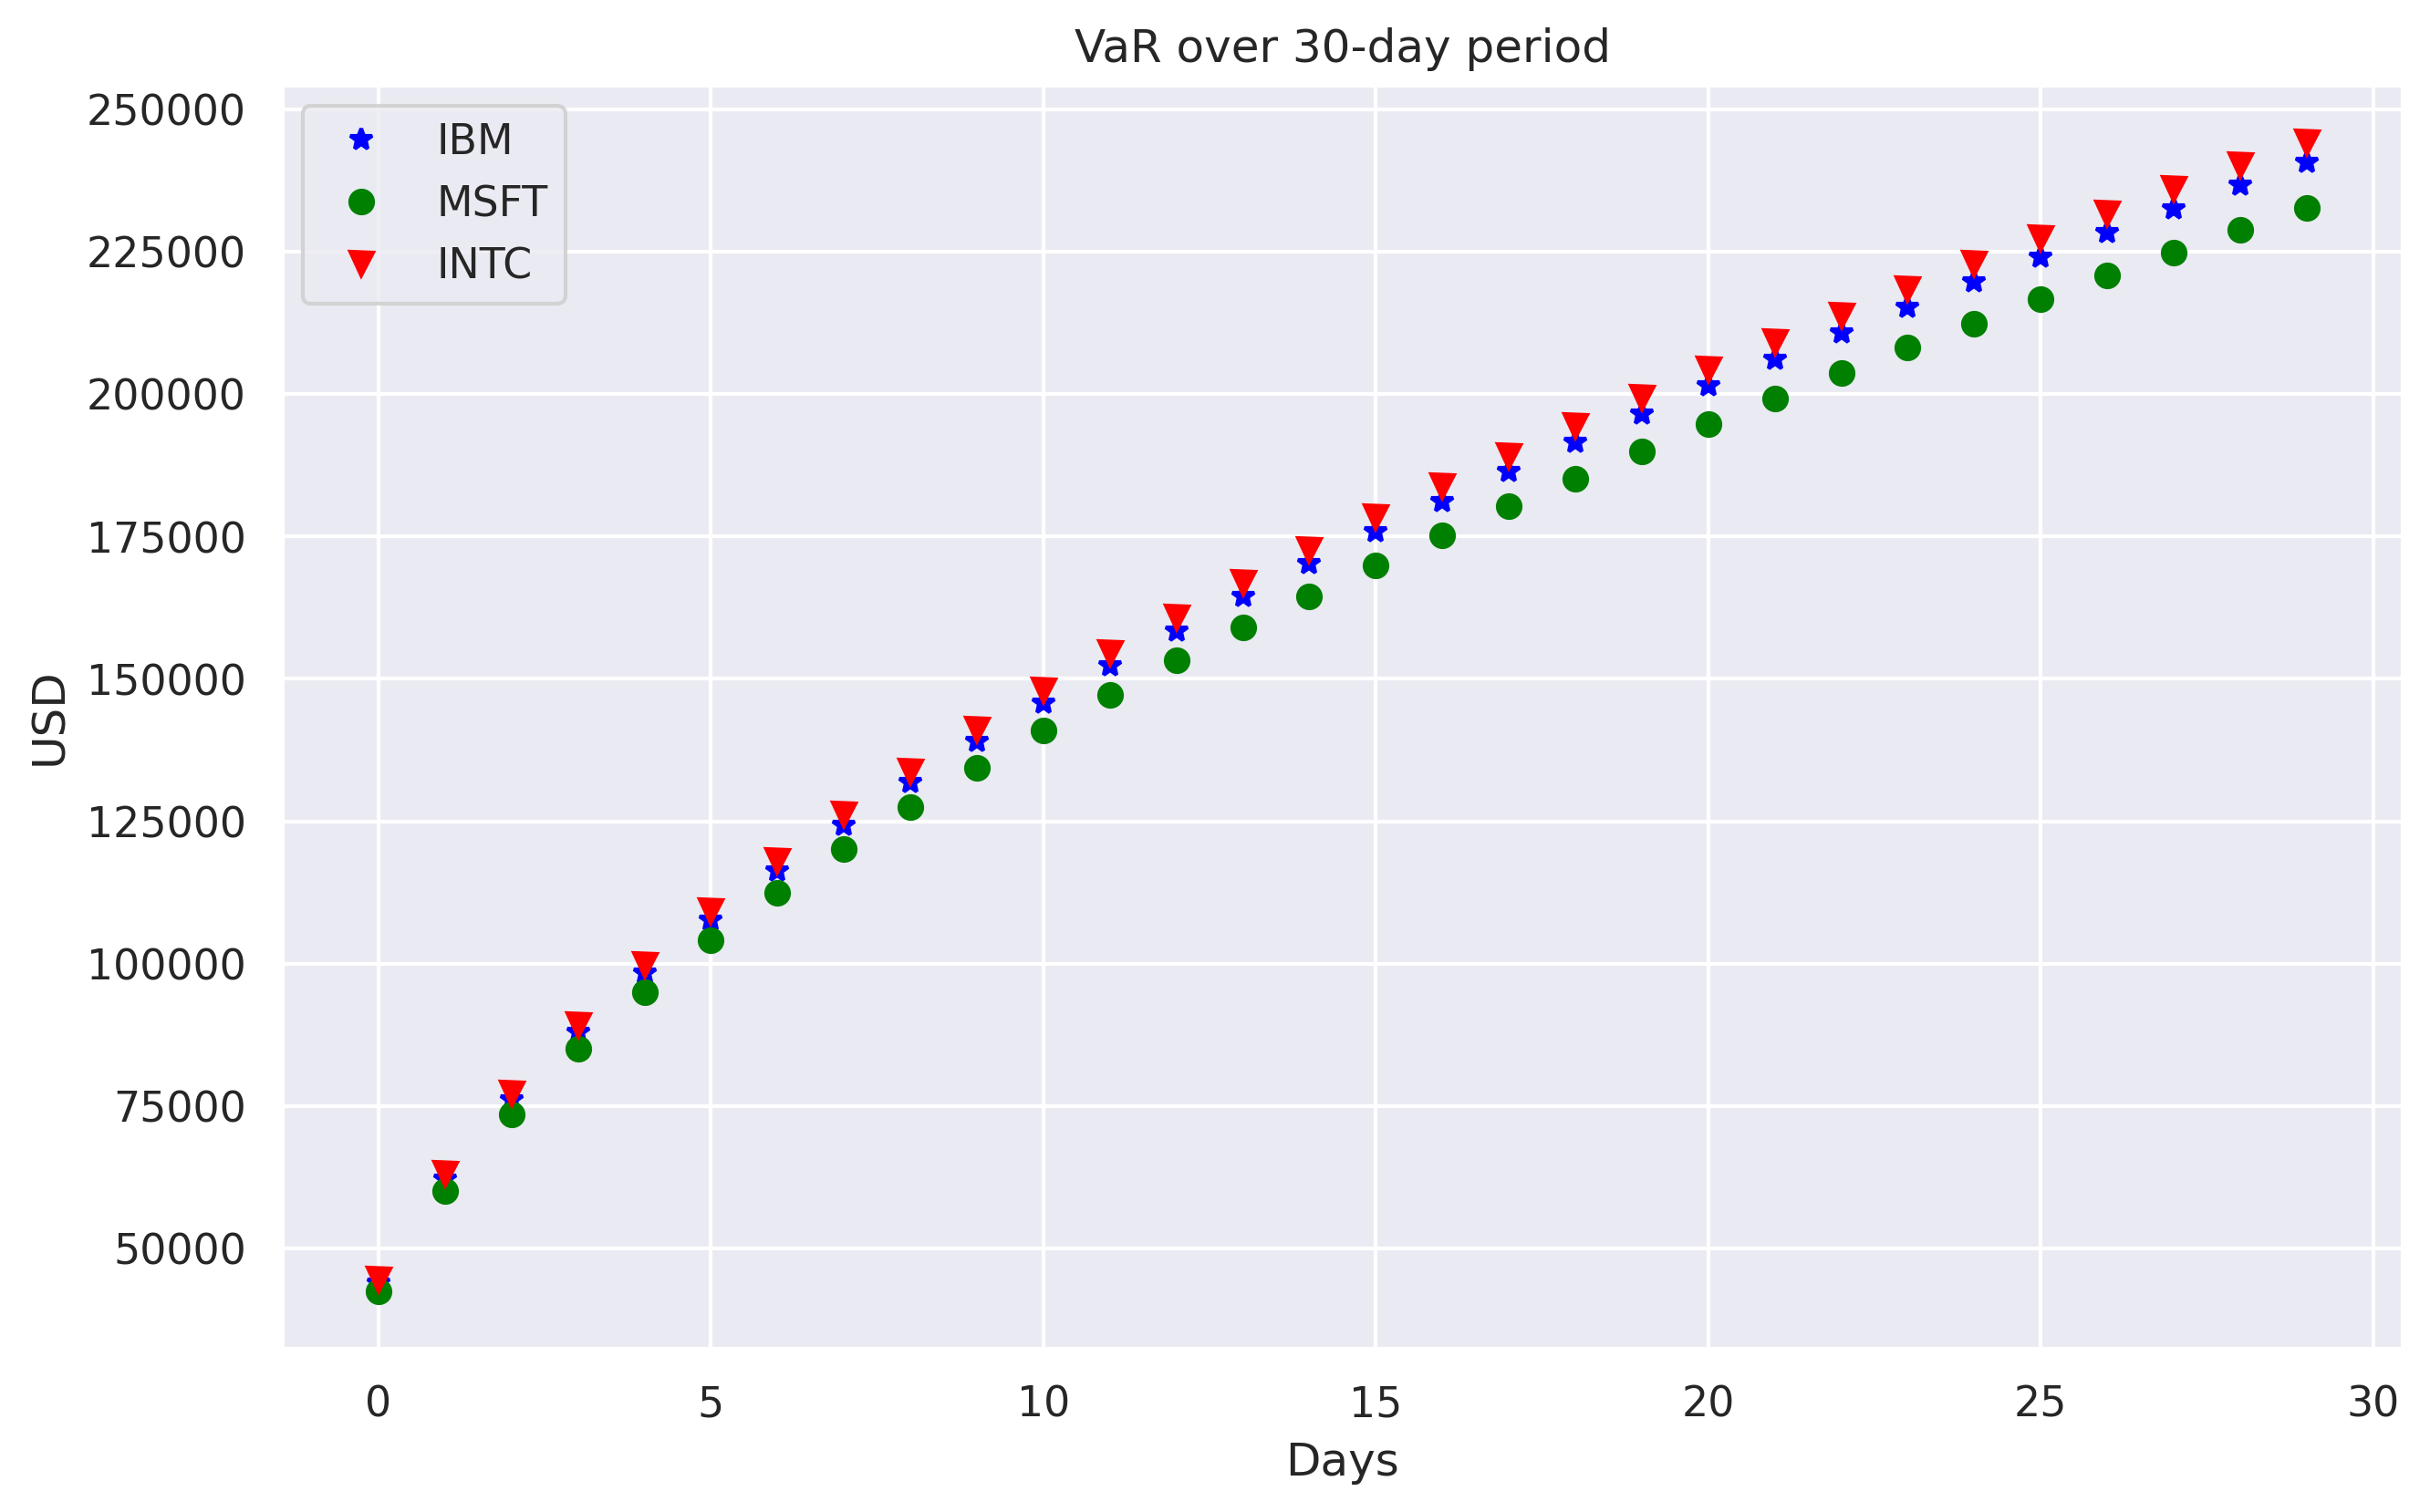

In [11]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical Simulation VaR

In [12]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [13]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of IBM's return is -0.0372
Historical VaR result for IBM is 37201.00 
----------------------------------------------------------------------
Based on historical values 95% of MSFT's return is -0.0426
Historical VaR result for MSFT is 42622.46 
----------------------------------------------------------------------
Based on historical values 95% of INTC's return is -0.0425
Historical VaR result for INTC is 42509.28 
----------------------------------------------------------------------


## Monte Carlo VaR

In [14]:
x = np.random.uniform(-1, 1, 100)
y = np.random.uniform(-1, 1, 100)

In [15]:
sample = 100
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [16]:
pi_calc(x,y)

pi value is 3.08


In [17]:
x = np.random.uniform(-1, 1, 1000000)
y = np.random.uniform(-1, 1, 1000000)

In [18]:
sample = 1000000

def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) < 1:
            point_inside_circle += 1
    print('pi value is {:.2f}'.format(4 * point_inside_circle/sample))

In [19]:
pi_calc(x,y)

pi value is 3.14


In [20]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [21]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,0.666080,-0.227413,-1.044779
1,0.515049,-0.050372,-1.170696
2,-0.609672,0.118937,0.286488
3,-1.275215,1.548361,1.826358
4,-0.385836,-0.190514,1.025071
...,...,...,...
995,1.613378,0.572101,-0.642828
996,-0.688903,-0.162452,0.851218
997,0.356500,-1.088791,1.141620
998,1.047158,1.008678,0.943218


In [22]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment *
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [23]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.5870
Simulation VaR result for Simulation 1 is 1586978.16 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.6217
Simulation VaR result for Simulation 2 is 1621727.17 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.6145
Simulation VaR result for Simulation 3 is 1614548.75 
----------------------------------------------------------------------


## The Marcenko-Pastur Theory

In [24]:
def mp_pdf(sigma2, q, obs):
    lambda_plus = sigma2 * (1 + q ** 0.5) ** 2
    lambda_minus = sigma2 * (1 - q ** 0.5) ** 2
    l = np.linspace(lambda_minus, lambda_plus, obs)
    pdf_mp = 1 / (2 * np.pi * sigma2 * q * l) \
             * np.sqrt((lambda_plus  - l)
             *  (l - lambda_minus))
    pdf_mp = pd.Series(pdf_mp, index=l)
    return pdf_mp

In [25]:
from sklearn.neighbors import KernelDensity

def kde_fit(bandwidth,obs,x=None):
    #kde = KernelDensity(bandwidth, kernel='gaussian')
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    if len(obs.shape) == 1:
        kde_fit=kde.fit(np.array(obs).reshape(-1, 1))
    if x is None:
        x=np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logprob = kde_fit.score_samples(x)
    pdf_kde = pd.Series(np.exp(logprob), index=x.flatten())
    return pdf_kde

In [26]:
corr_mat = np.random.normal(size=(10000, 1000))
corr_coef = np.corrcoef(corr_mat, rowvar=0)
sigma2 = 1
obs = corr_mat.shape[0]
q = corr_mat.shape[0] / corr_mat.shape[1]

def plotting(corr_coef, q):
    ev, _ = np.linalg.eigh(corr_coef)
    idx = ev.argsort()[::-1]
    eigen_val = np.diagflat(ev[idx])
    pdf_mp = mp_pdf(1., q=corr_mat.shape[1] / corr_mat.shape[0],
                    obs=1000)
    kde_pdf = kde_fit(0.01, np.diag(eigen_val))
    ax = pdf_mp.plot(title="Marchenko-Pastur Theorem",
                     label="M-P", style='r--')
    kde_pdf.plot(label="Empirical Density", style='o-', alpha=0.3)
    ax.set(xlabel="Eigenvalue", ylabel="Frequency")
    ax.legend(loc="upper right")
    plt.show()
    return plt

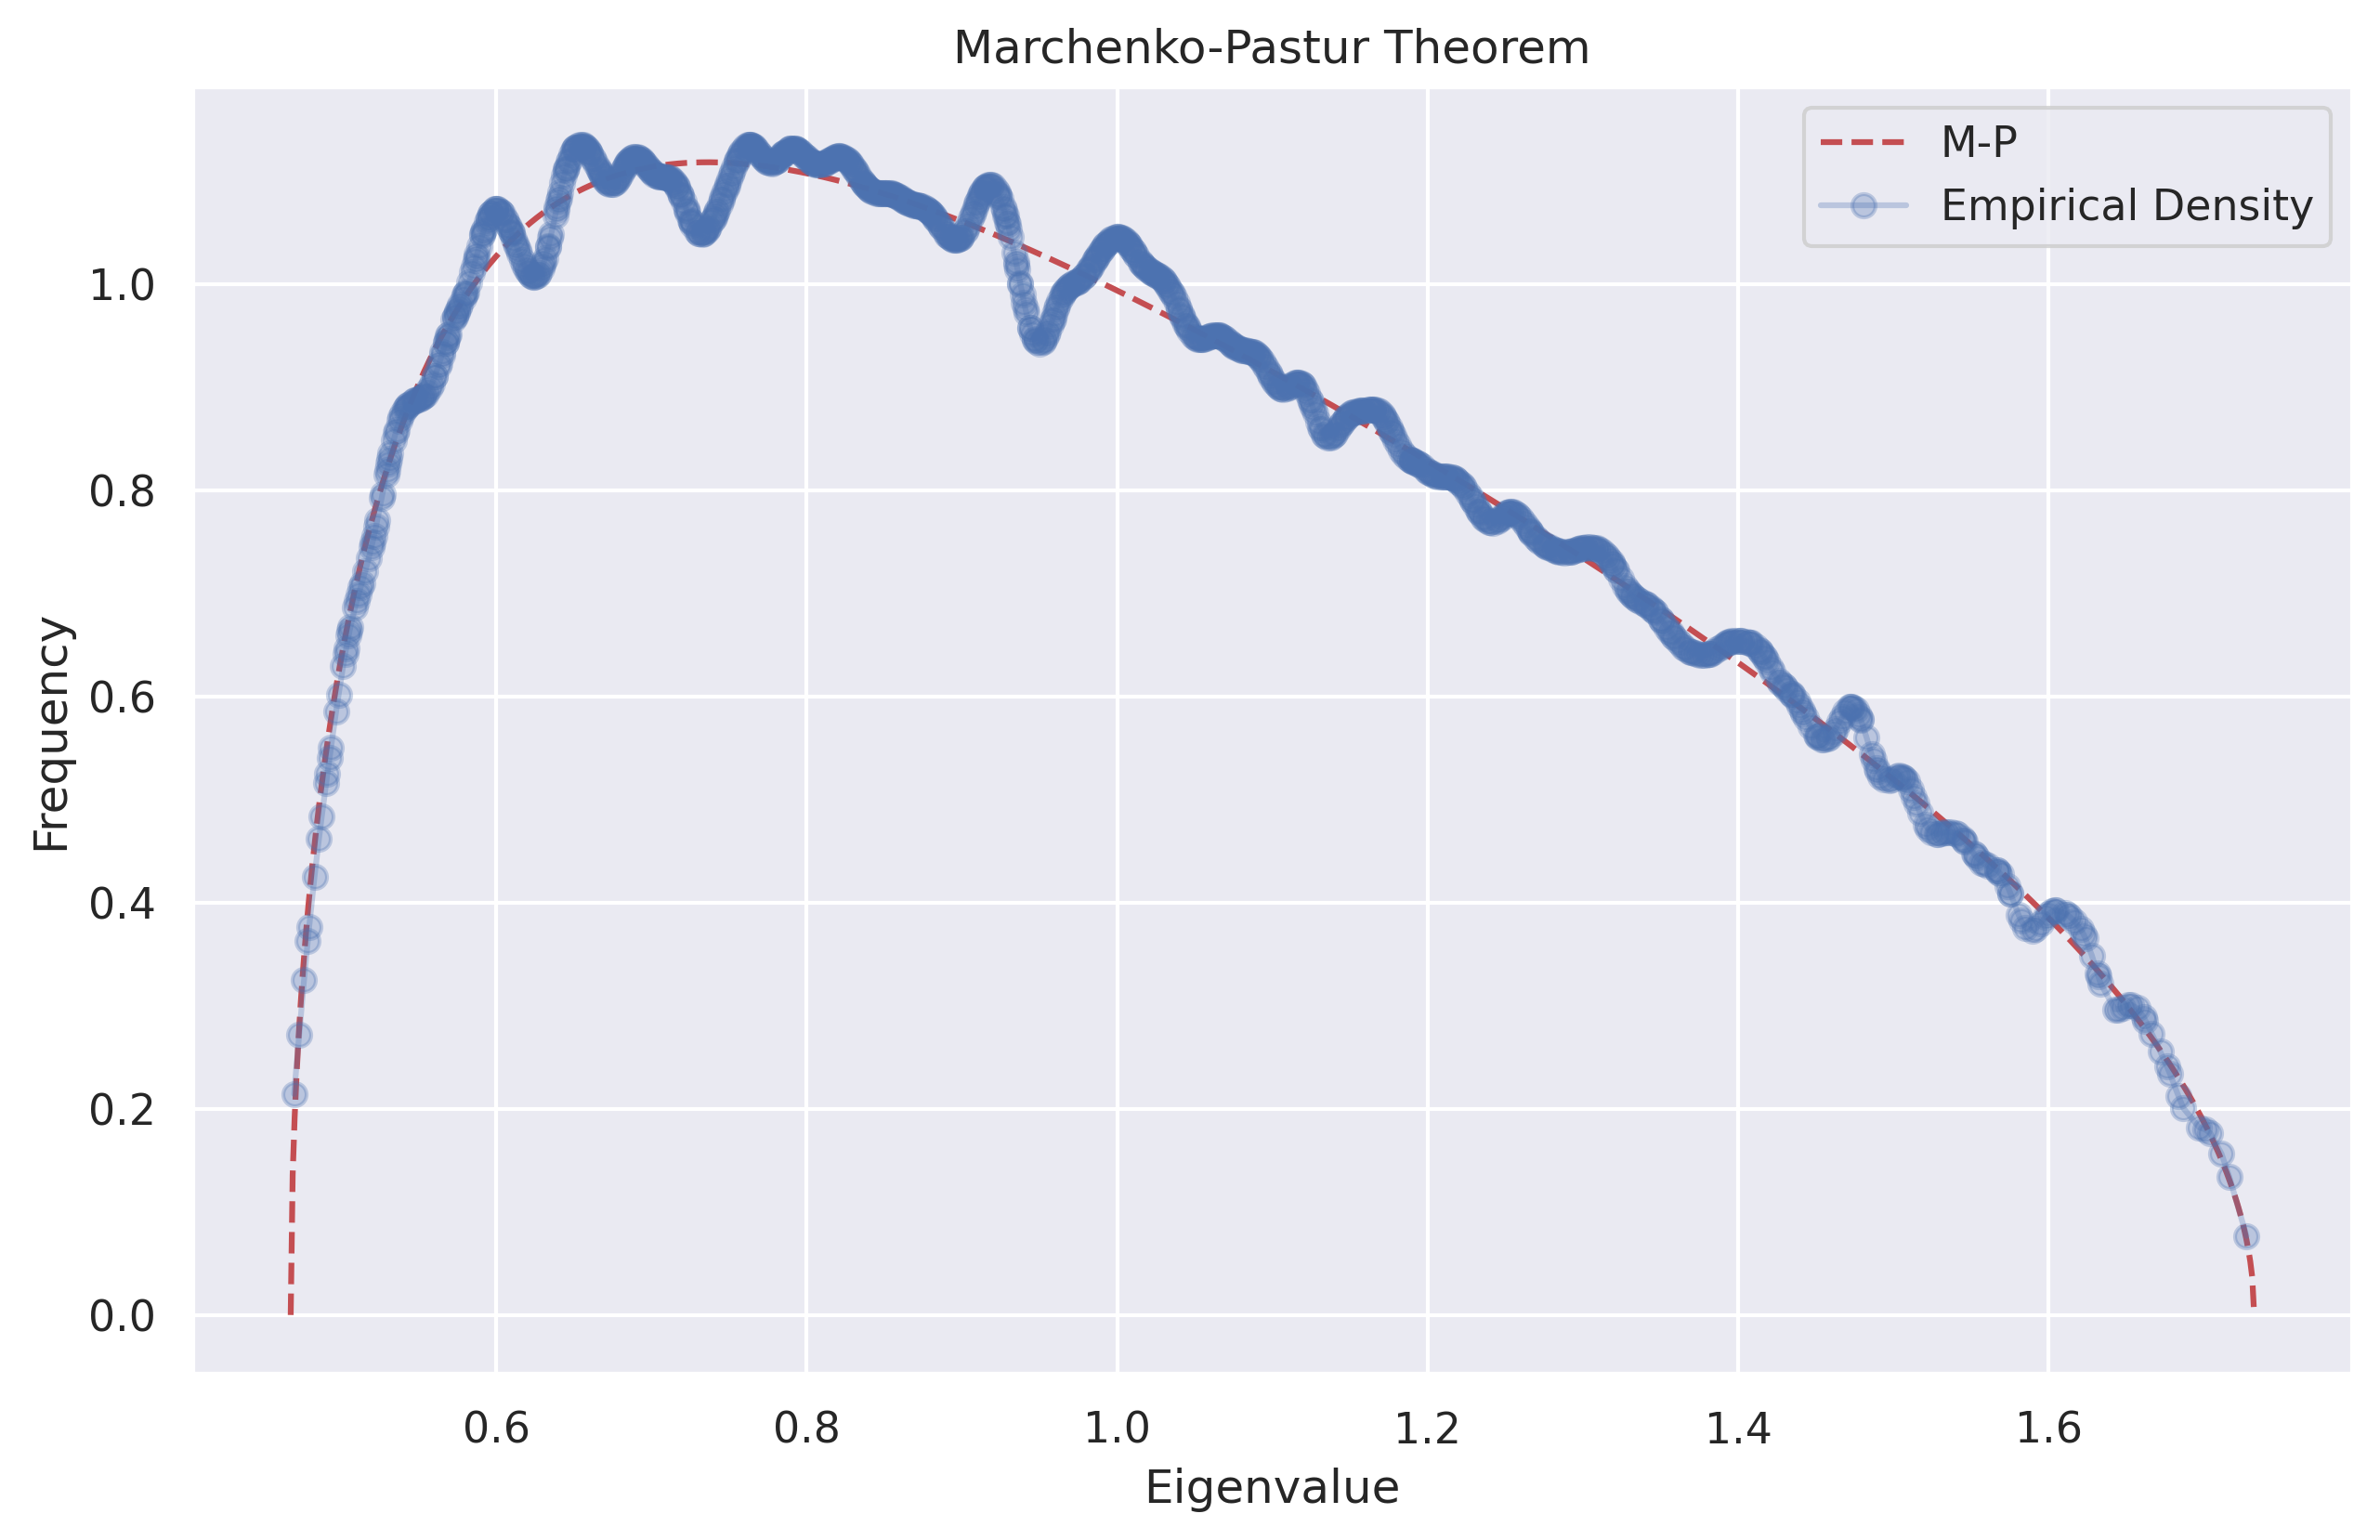

In [27]:
plotting(corr_coef, q)
plt.show()

## Denoising

In [63]:
# ==============================
# DENOISING + VaR via Riskfolio
# ==============================
import numpy as np
import pandas as pd
from scipy.stats import norm
import riskfolio as rp

# --- inputs you already have ---
# stocks  -> price DataFrame (columns = tickers)
# initial_investment, conf_level

# prices -> returns
stock_prices = stocks.copy()
stocks_returns = np.log(stock_prices).diff().dropna()

# raw covariance
cov_matrix = stocks_returns.cov()

# weights (unchanged)
weights = np.repeat(1.0 / stocks.shape[1], stocks.shape[1])

# ==============================
# DENOISING (Riskfolio)
# ==============================
# Riskfolio estimates the covariance using the eigenvalue-kernel approach
# similar in spirit to the MP+KDE denoising flow
kde_bwidth = 0.25  # your bandwidth
cov_matrix_denoised_np = rp.ParamsEstimation.covar_matrix(
    stocks_returns,
    method="fixed",      # KDE bandwidth 'fixed'
    bWidth=kde_bwidth,
    detone=False,        # keep market mode unless you want to remove it
    mkt_comp=1
)
cov_matrix_denoised = pd.DataFrame(
    cov_matrix_denoised_np,
    index=cov_matrix.index,
    columns=cov_matrix.columns
)

# ==============================
# VaR FUNCTIONS (unchanged names)
# ==============================
def VaR_parametric(initial_investment, conf_level):
    port_std = float(np.sqrt(weights.T @ cov_matrix.values @ weights))
    mu_p = float(stocks_returns.mean().to_numpy() @ weights)
    alpha = norm.ppf(conf_level)
    VaR_params = initial_investment * (alpha * port_std - mu_p)
    print('--' * 25)
    return VaR_params

def VaR_parametric_denoised(initial_investment, conf_level):
    # portfolio VaR using denoised covariance
    port_std = float(np.sqrt(weights.T @ cov_matrix_denoised.values @ weights))
    mu_p = float(stocks_returns.mean().to_numpy() @ weights)
    alpha = norm.ppf(conf_level)
    VaR_params = initial_investment * (alpha * port_std - mu_p)
    # NOTE: printing once per ticker would repeat the same portfolio VaR.
    # If you really want that printout, uncomment below:
    # for i, j in zip(stocks.columns, range(len(stocks.columns))):
    #     print("Parametric VaR result for {} is {} ".format(i, VaR_params))
    print('--' * 25)
    return VaR_params

# ==============================
# OPTIONAL: different VaR per asset (standalone)
# (added only as a helper; uses your variables)
# ==============================
def VaR_parametric_per_asset_denoised(initial_investment, conf_level):
    alpha = norm.ppf(conf_level)
    mu_vec = stocks_returns.mean()
    # per-asset σ from denoised covariance diagonal
    sigma_vec = pd.Series(
        np.sqrt(np.diag(cov_matrix_denoised.values)),
        index=cov_matrix_denoised.index
    )
    var_series = initial_investment * (alpha * sigma_vec - mu_vec)
    for i in stocks.columns:
        print(f"Parametric VaR (denoised) result for {i} is {var_series.loc[i]}")
    print('--' * 25)
    return var_series

# ==============================
# EXAMPLE RUN
# ==============================
# Portfolio VaR (raw)
VaR_parametric(initial_investment, conf_level)
# Portfolio VaR (denoised via Riskfolio)
VaR_parametric_denoised(initial_investment, conf_level)
# Different VaR per asset (denoised standalone) — optional
# VaR_parametric_per_asset_denoised(initial_investment, conf_level)


--------------------------------------------------
--------------------------------------------------


np.float64(4245.418546583027)

## Checking Sub-additivity

In [29]:
asset1 = [-0.5, 0, 0.1, 0.4]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1))
asset2 = [0, -0.5, 0.01, 0.4]
VaR2 = np.percentile(asset2, 90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2))
VaR_all = np.percentile(asset1 + asset2, 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))

VaR for the Asset 1 is 0.3100
VaR for the Asset 2 is 0.2830
VaR for the portfolio is 0.4000


In [30]:
asset1 = [-0.5, 0, 0.05, 0.03]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1))
asset2 = [0, -0.5, 0.02, 0.8]
VaR2 = np.percentile(asset2,90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2))
VaR_all = np.percentile(asset1 + asset2 , 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))

VaR for the Asset 1 is 0.0440
VaR for the Asset 2 is 0.5660
VaR for the portfolio is 0.2750


## Expected Shortfall

In [31]:
def ES_parametric(initial_investment , conf_level):
    alpha = - norm.ppf(1 - conf_level,stocks_returns_mean,port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment * alpha)[j]
        ES_param = (1 / (1 - conf_level)) \
                   * initial_investment \
                   * norm.expect(lambda x: x,
                                 lb = norm.ppf(conf_level,
                                               stocks_returns_mean[j],
                                               port_std),
                                 loc = stocks_returns_mean[j],
                                 scale = port_std)
        print(f"Parametric ES result for {i} is {ES_param}")

In [32]:
ES_parametric(initial_investment, conf_level)

Parametric ES result for IBM is 54807.579547676934
Parametric ES result for MSFT is 56269.64418651517
Parametric ES result for INTC is 54159.234988169694


In [33]:
def ES_historical(initial_investment, conf_level):
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        ES_hist_percentile95 = np.percentile(stocks_returns.loc[:, i],
                                             5)
        ES_historical = stocks_returns[str(i)][stocks_returns[str(i)] <=
                                               ES_hist_percentile95]\
                                               .mean()
        print("Historical ES result for {} is {:.4f} "
              .format(i, initial_investment * ES_historical))

In [34]:
ES_historical(initial_investment, conf_level)

Historical ES result for IBM is -64802.3576 
Historical ES result for MSFT is -65765.0297 
Historical ES result for INTC is -88462.7492 


## Bid-Ask Spread

In [35]:
bid_ask = pd.read_csv('bid_ask.csv')

In [36]:
bid_ask['mid_price'] = (bid_ask['ASKHI'] + bid_ask['BIDLO']) / 2
buyer_seller_initiated = []
for i in range(len(bid_ask)):
    if bid_ask['PRC'][i] > bid_ask['mid_price'][i]:
        buyer_seller_initiated.append(1)
    else:
        buyer_seller_initiated.append(0)

bid_ask['buyer_seller_init'] = buyer_seller_initiated

In [37]:
effective_cost = []
for i in range(len(bid_ask)):
    if bid_ask['buyer_seller_init'][i] == 1:
        effective_cost.append((bid_ask['PRC'][i] -
                               bid_ask['mid_price'][i]) /
                               bid_ask['mid_price'][i])
    else:
        effective_cost.append((bid_ask['mid_price'][i] -
                               bid_ask['PRC'][i])/
                               bid_ask['mid_price'][i])
bid_ask['effective_cost'] = effective_cost

In [38]:
bid_ask['quoted'] = bid_ask['ASKHI'] - bid_ask['BIDLO']
bid_ask['prop_quoted'] = (bid_ask['ASKHI'] - bid_ask['BIDLO']) /\
                         bid_ask['mid_price']
bid_ask['effective'] = 2 * abs(bid_ask['PRC'] - bid_ask['mid_price'])
bid_ask['prop_effective'] = 2 * abs(bid_ask['PRC'] -
                                    bid_ask['mid_price']) /\
                                    bid_ask['PRC']

In [39]:
spread_meas = bid_ask.iloc[:, -5:]
spread_meas.corr()

,effective_cost,quoted,prop_quoted,effective,prop_effective
effective_cost,1.000000,0.441290,0.727917,0.800894,0.999847
quoted,0.441290,1.000000,0.628526,0.717246,0.442053
prop_quoted,0.727917,0.628526,1.000000,0.514979,0.728687
effective,0.800894,0.717246,0.514979,1.000000,0.800713
prop_effective,0.999847,0.442053,0.728687,0.800713,1.000000


In [40]:
spread_meas.describe()

,effective_cost,quoted,prop_quoted,effective,prop_effective
count,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.004247,1.592583,0.015869,0.844314,0.008484
std,0.003633,0.921321,0.007791,0.768363,0.007257
min,0.000000,0.320000,0.003780,0.000000,0.000000
25%,0.001517,0.979975,0.010530,0.300007,0.003029
50%,0.003438,1.400000,0.013943,0.610000,0.006874
75%,0.005854,1.962508,0.019133,1.180005,0.011646
max,0.023283,8.110000,0.055451,6.750000,0.047677


In [41]:
high_corr = spread_meas.corr().unstack()\
            .sort_values(ascending=False).drop_duplicates()
high_corr[(high_corr > 0.80) & (high_corr != 1)]

,,0
prop_effective,effective_cost,0.999847
effective_cost,effective,0.800894
prop_effective,effective,0.800713


In [42]:
sorted_spread_measures = bid_ask.iloc[:, -5:-2]

In [43]:
cross_sec_mean_corr = sorted_spread_measures.mean(axis=1).mean()
std_corr = sorted_spread_measures.std().sum() / 3

In [44]:
df = pd.DataFrame(index=stocks.columns)
last_prices = []
for i in symbols:
    last_prices.append(stocks[i].iloc[-1])
df['last_prices'] = last_prices

In [45]:
def ES_parametric(initial_investment, conf_level):
    ES_params = [ ]
    alpha = - norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i,j in zip(stocks.columns,range(len(stocks.columns))):
        VaR_param = (initial_investment * alpha)[j]
        ES_param = (1 / (1 - conf_level)) \
                   * norm.expect(lambda x: VaR_param, lb = conf_level)
        ES_params.append(ES_param)
    return ES_params

In [46]:
ES_params = ES_parametric(initial_investment, conf_level)
for i in range(len(symbols)):
    print(f'The ES result for {symbols[i]} is {ES_params[i]}')

The ES result for IBM is 150358.46568009976
The ES result for MSFT is 145356.56340945416
The ES result for INTC is 152576.53185734944


In [47]:
k = 1.96

for i, j in zip(range(len(symbols)), symbols):
    print('The liquidity Adjusted ES of {} is {}'
          .format(j, ES_params[i] + (df.loc[j].values[0] / 2) *
                  (cross_sec_mean_corr + k * std_corr)))

The liquidity Adjusted ES of IBM is 150414.1961515002
The liquidity Adjusted ES of MSFT is 145478.7770550958
The liquidity Adjusted ES of INTC is 152601.8058215678


## PCA

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [49]:
scaler = StandardScaler()
spread_meas_scaled = scaler.fit_transform(np.abs(spread_meas))
pca = PCA(n_components=5)
prin_comp = pca.fit_transform(spread_meas_scaled)

In [50]:
var_expl = np.round(pca.explained_variance_ratio_, decimals=4)
cum_var = np.cumsum(np.round(pca.explained_variance_ratio_,
                             decimals=4))
print('Individually Explained Variances are:\n{}'.format(var_expl))
print('=='*30)
print('Cumulative Explained Variances are: {}'.format(cum_var))

Individually Explained Variances are:
[0.7494 0.1461 0.0983 0.0062 0.    ]
Cumulative Explained Variances are: [0.7494 0.8955 0.9938 1.     1.    ]


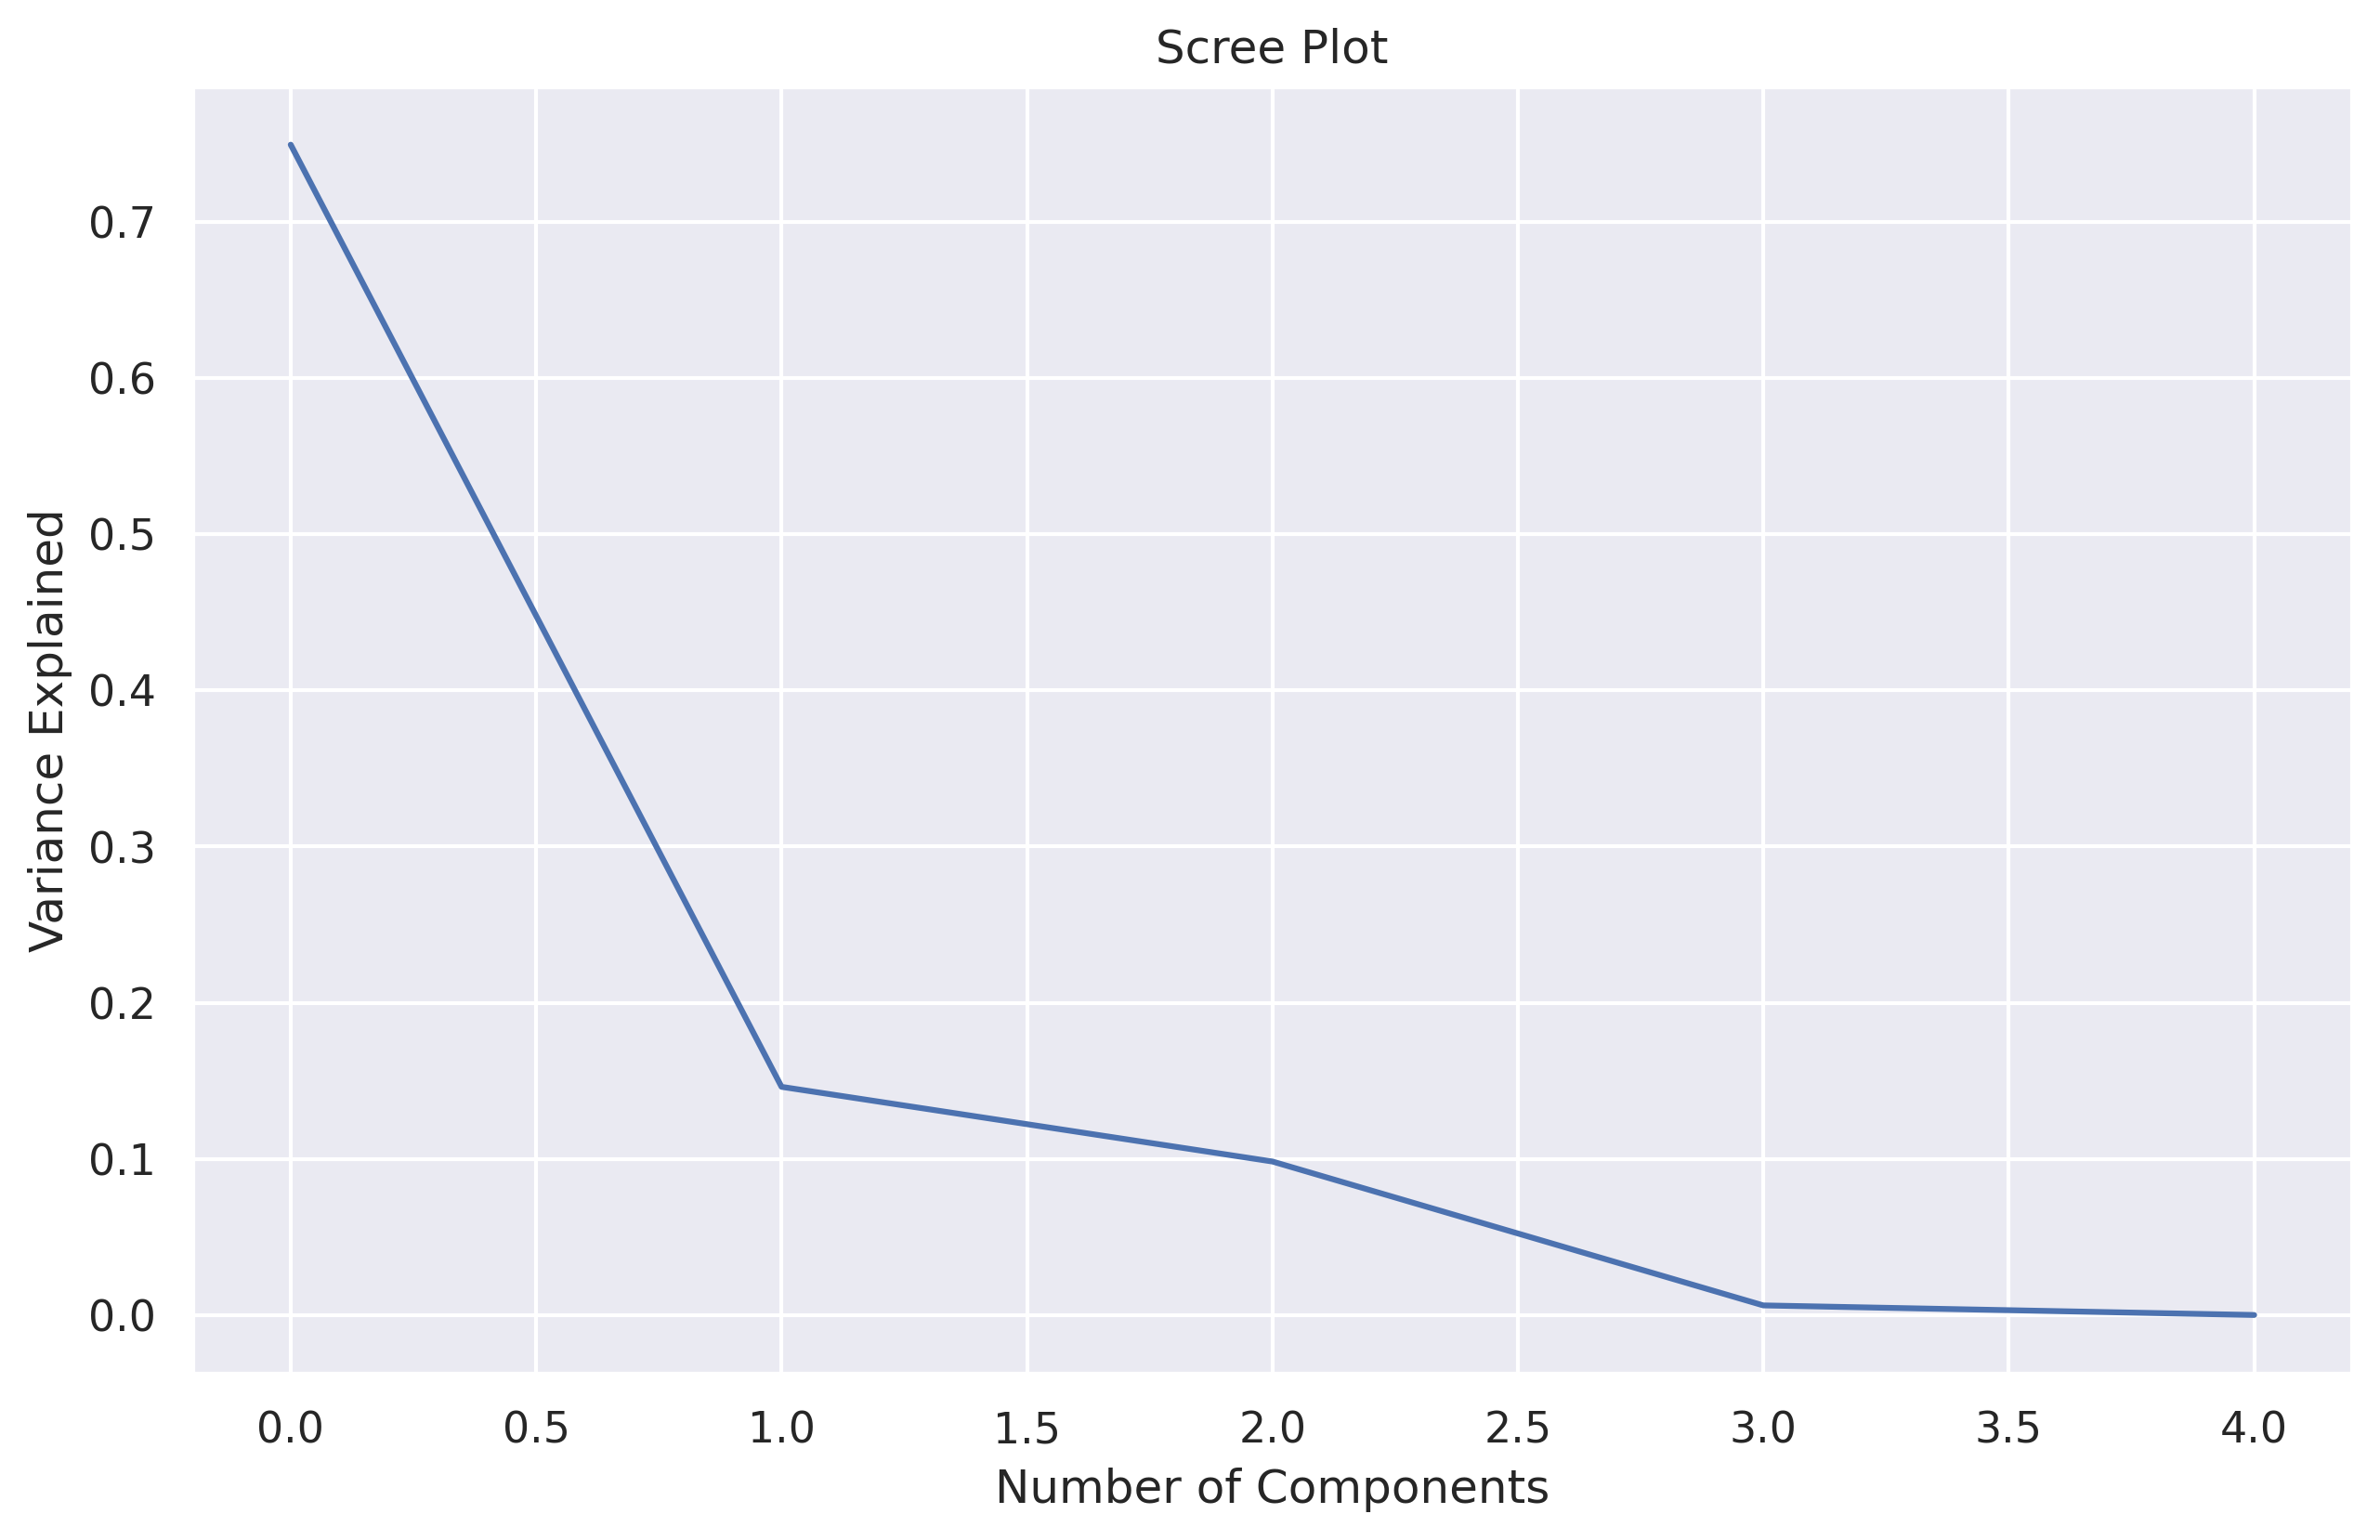

In [51]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

In [52]:
pca = PCA(n_components=2)
pca.fit(np.abs(spread_meas_scaled))
prin_comp = pca.transform(np.abs(spread_meas_scaled))
prin_comp = pd.DataFrame(np.abs(prin_comp), columns = ['Component 1',
                                                       'Component 2'])
print(pca.explained_variance_ratio_*100)

[65.65640435 19.29704671]


In [53]:
def myplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex * 4, ys * scaley * 4, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color = 'r',
                  alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0], coeff[i, 1], "Var"+str(i),
                     color='black')
        else:
            plt.text(coeff[i,0 ], coeff[i, 1], labels[i],
                     color='black')

    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [54]:
spread_measures_scaled_df = pd.DataFrame(spread_meas_scaled,
                                         columns=spread_meas.columns)

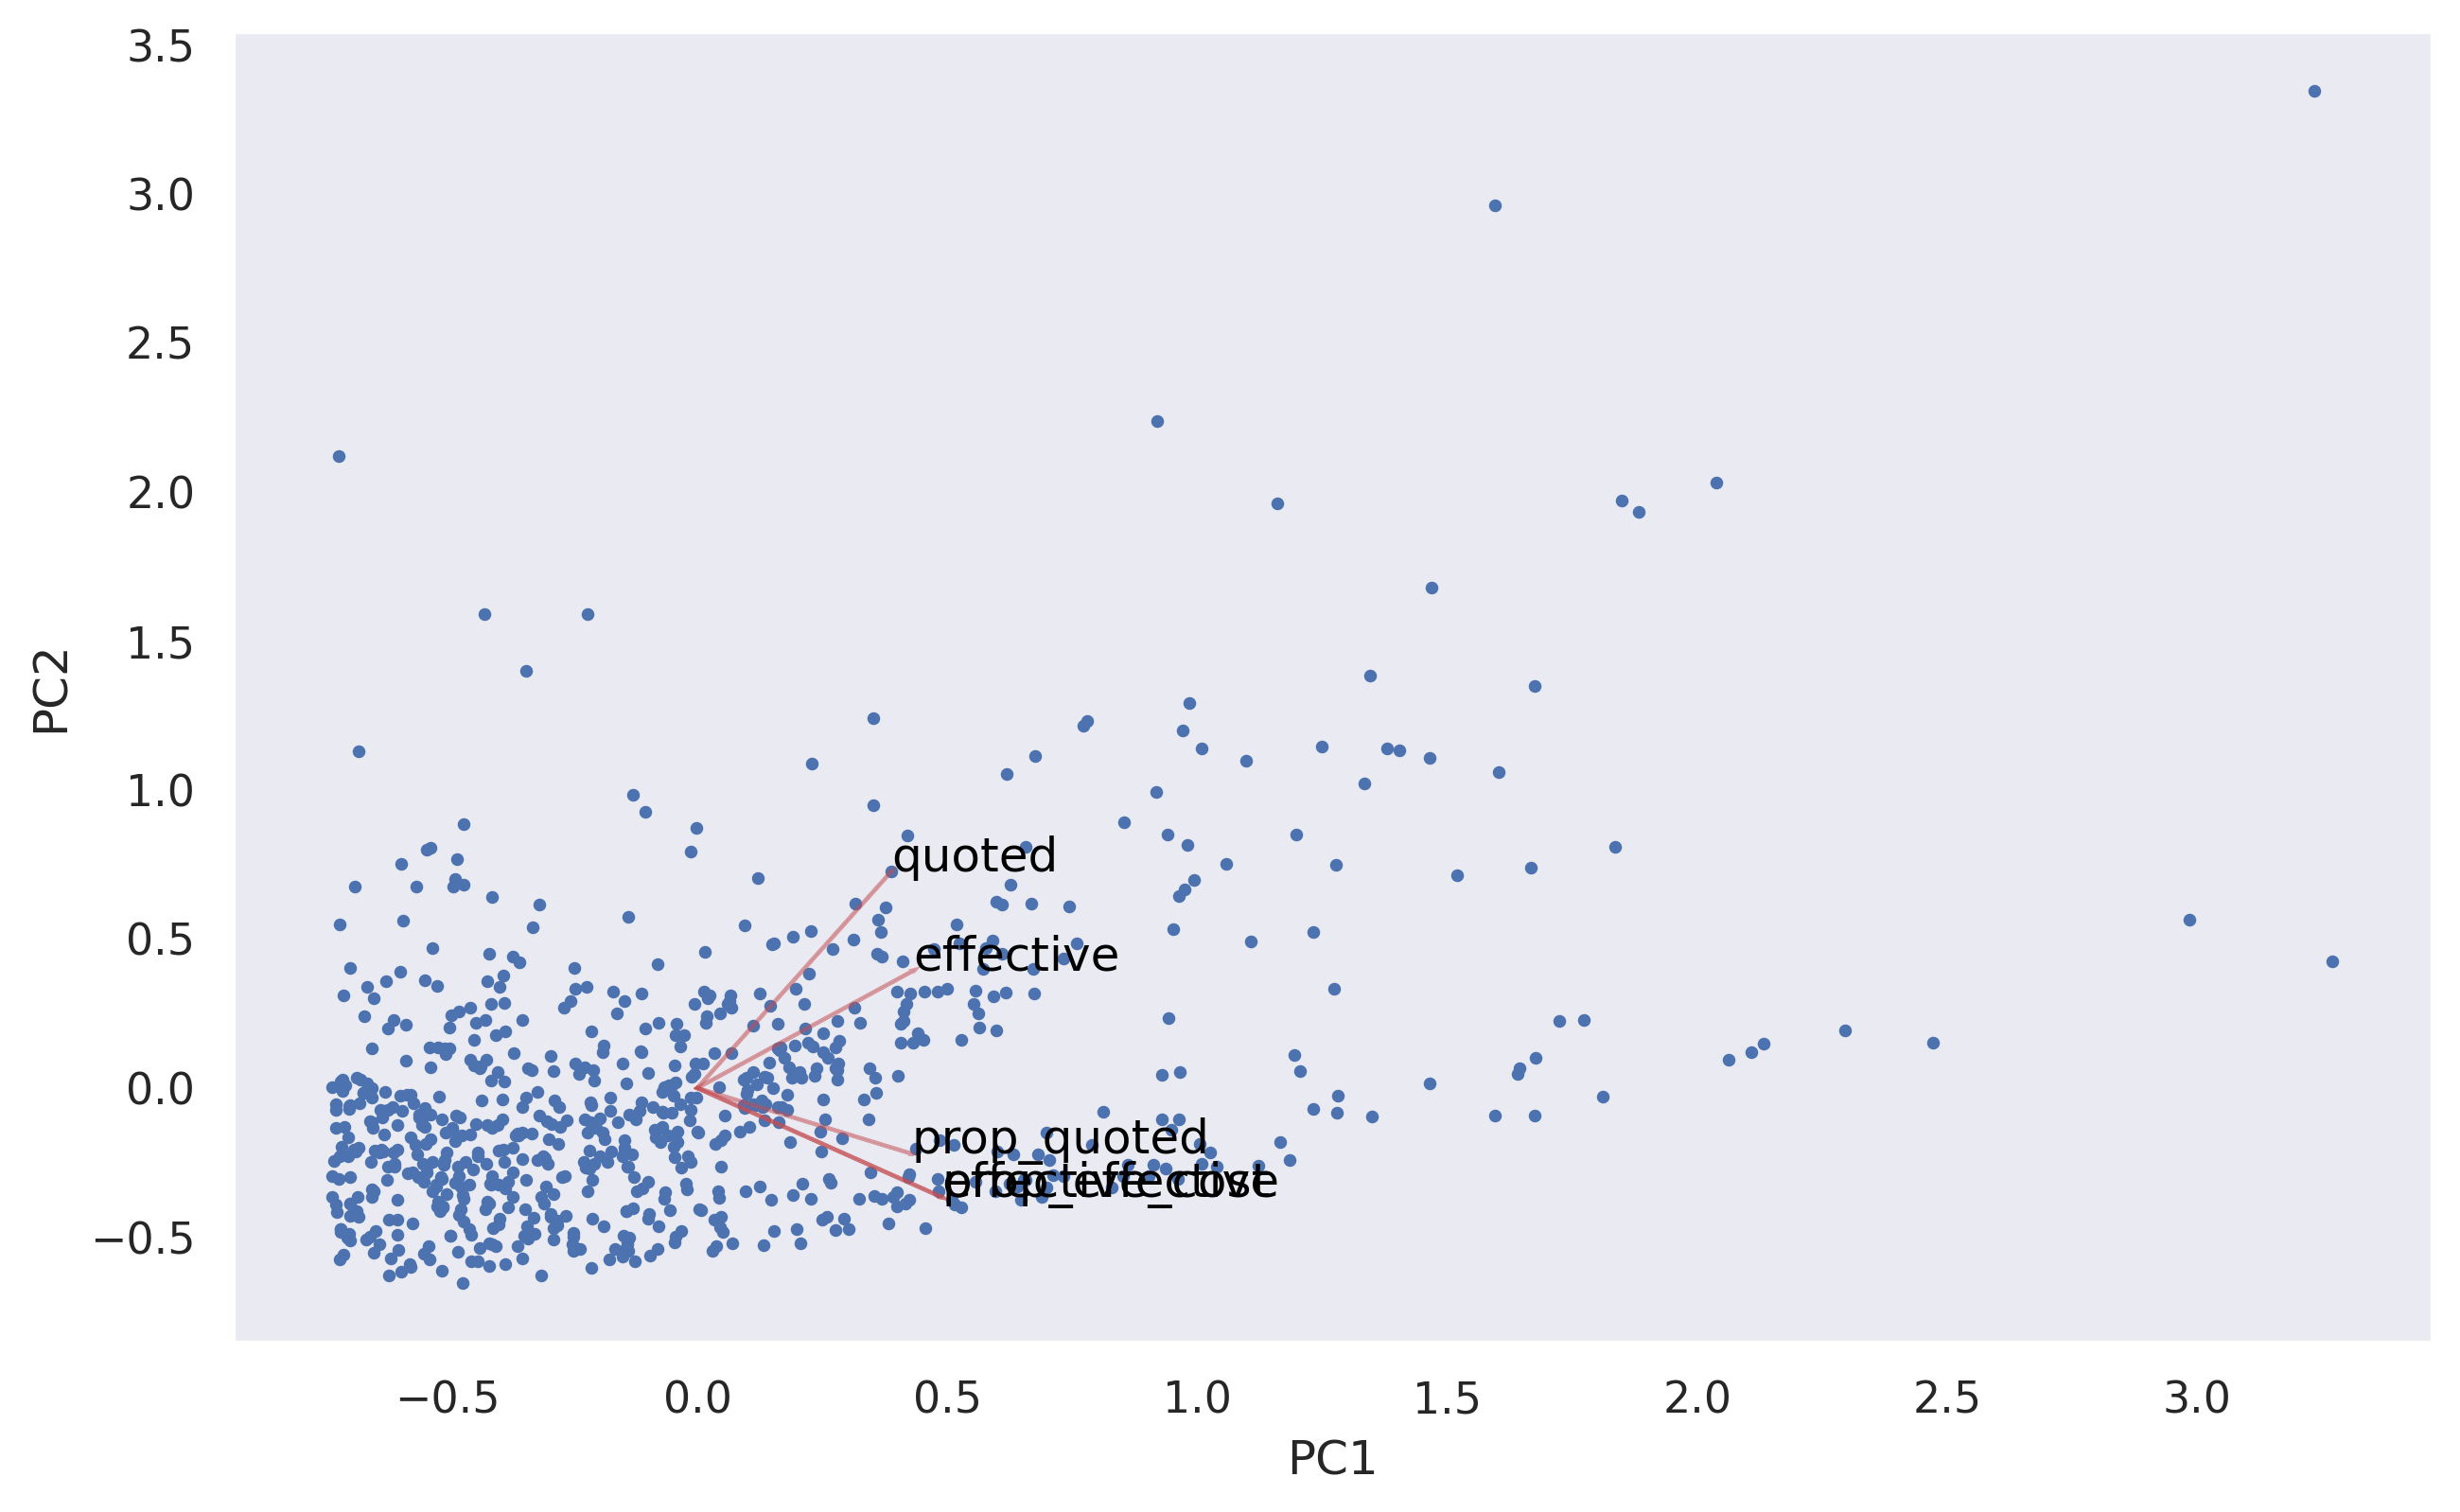

In [55]:
myplot(np.array(spread_measures_scaled_df)[:, 0:2],
       np.transpose(pca.components_[0:2,:]),
       list(spread_measures_scaled_df.columns))
plt.show()

In [56]:
prin_comp1_rescaled = prin_comp.iloc[:,0] * prin_comp.iloc[:,0].std()\
                      + prin_comp.iloc[:, 0].mean()
prin_comp2_rescaled = prin_comp.iloc[:,1] * prin_comp.iloc[:,1].std()\
                      + prin_comp.iloc[:, 1].mean()
prin_comp_rescaled = pd.concat([prin_comp1_rescaled,
                                prin_comp2_rescaled],
                               axis=1)
prin_comp_rescaled.head()

,Component 1,Component 2
0,1.766661,1.256192
1,4.835170,1.939466
2,3.611486,1.551059
3,0.962666,0.601529
4,0.831065,0.734612


In [57]:
mean_pca_liq = prin_comp_rescaled.mean(axis=1).mean()
mean_pca_liq

np.float64(1.0647130086973824)

In [58]:
k = 1.96
for i, j in zip(range(len(symbols)), symbols):
    print('The liquidity Adjusted ES of {} is {}'
          .format(j, ES_params[i] + (df.loc[j].values[0] / 2) *
                  (mean_pca_liq + k * std_corr)))

The liquidity Adjusted ES of IBM is 150439.81008103088
The liquidity Adjusted ES of MSFT is 145534.94689591162
The liquidity Adjusted ES of INTC is 152613.4218284341
